In [1]:

"""
===============
Metrics example
===============
"""

'\n===============\nMetrics example\n===============\n'

In [2]:
# This example demonstrates different metrics available in Stone Soup and how they
# can be used with the :class:`~.MultiManager` to assess tracking performance. It also
# demonstrates how to use the :class:`~.MetricPlotter` class to easily generate metric plots for
# visualisation.
#
# To generate metrics, we need:
#  - At least one :class:`~.MetricGenerator` - these are used to determine the metric type
#    we want to generate and to compute the metrics themselves.
#  - The :class:`~.MultiManager` metric manager - this is used to hold the metric generator(s)
#    as well as all the ground truth, track, and detection sets we want to generate our
#    metrics from. We will generate our metrics using the :meth:`generate_metrics` method
#    of the :class:`~.MultiManager` class.
#
# In this example, we will create a variety of metric generators for different types of metrics.
# These metrics will be used to assess and compare tracks produced from the same set of ground
# truth paths and detections by the Extended Kalman Filter and the Particle Filter.

In [3]:
# Create metric generators and metric manager
# -------------------------------------------
# In this section we create the metric generators in preparation for generating metrics later.
#
# First, we create some :class:`~.BasicMetrics` generators that will show us the number of tracks,
# the number of targets, and the ratio between them. As with all the metric generators,
# we must give ours a unique name to identify it later, and the keys for our tracks and
# ground truth data (and detections set if relevant). When we generate the metrics, these keys
# will be used to access the data stored in the MultiManager and allow us to specify
# which tracks or truths we want to generate metrics for.
#
# NB: in all metrics that take a track and a truth as input, we can input two tracks
# instead to calculate track to track comparisons. This is relevant in scenarios where a
# second set of tracks is used as a proxy for ground truth. To do this, set the *tracks_key*
# parameter to the tracks set and the *truths_key* parameter to the second tracks set that is
# being used as a ground truth proxy.

from stonesoup.metricgenerator.basicmetrics import BasicMetrics

basic_EKF = BasicMetrics(generator_name='basic_EKF', tracks_key='EKF_tracks', truths_key='truths')
basic_PF = BasicMetrics(generator_name='basic_PF', tracks_key='PF_tracks', truths_key='truths')

In [4]:
# Next, we create the Optimal SubPattern Assignment (OSPA) metric generator. This metric is
# calculated at each time step to show how far the tracks are from the ground truth paths. It
# returns an overall multi-track to multi-ground-truth missed distance for each time step.
#
# The generator has two additional properties: :math:`p \in [1,\infty]` for outlier sensitivity
# and :math:`c > 1` for cardinality penalty. [#]_

from stonesoup.metricgenerator.ospametric import OSPAMetric

ospa_EKF_truth = OSPAMetric(c=40, p=1, generator_name='OSPA_EKF-truth',
                            tracks_key='EKF_tracks', truths_key='truths')
ospa_PF_truth = OSPAMetric(c=40, p=1, generator_name='OSPA_PF-truth',
                           tracks_key='PF_tracks', truths_key='truths')
ospa_EKF_PF = OSPAMetric(c=40, p=1, generator_name='OSPA_EKF-PF',
                         tracks_key='EKF_tracks', truths_key='PF_tracks')

In [5]:
# Next, we create the Single Integrated Air Picture (SIAP) metric generators. These metrics are
# applicable to tracking in general - not just the air domain. [#]_
#
# The SIAP generators will generate a series of different SIAP metrics that
# provide information about the accuracy of the tracking. They generate different SIAP
# metrics for each time step and calculate averages. SIAP metric averages
# and more explanation into the different plotted metrics are provided later.
#
# The SIAP Metrics require a way to associate tracks to truth, so we'll use a Track to Truth
# associator which uses Euclidean distance measure by default.

from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.measures import Euclidean

siap_EKF_truth = SIAPMetrics(position_measure=Euclidean((0, 2)),
                             velocity_measure=Euclidean((1, 3)),
                             generator_name='SIAP_EKF-truth',
                             tracks_key='EKF_tracks',
                             truths_key='truths'
                             )

siap_PF_truth = SIAPMetrics(position_measure=Euclidean((0, 2)),
                            velocity_measure=Euclidean((1, 3)),
                            generator_name='SIAP_PF-truth',
                            tracks_key='PF_tracks',
                            truths_key='truths'
                            )

from stonesoup.dataassociator.tracktotrack import TrackToTruth

associator = TrackToTruth(association_threshold=30)

In [6]:
# Next, we create metric generators for the :class:`~.SumofCovarianceNormsMetric`. They will
# calculate the sum of the covariance matrix norms of each track state at each time step. These
# metrics produced will indicate how uncertain the tracks we have produced are. Higher sum of
# covariance norms means higher uncertainty.

from stonesoup.metricgenerator.uncertaintymetric import SumofCovarianceNormsMetric

sum_cov_norms_EKF = SumofCovarianceNormsMetric(tracks_key='EKF_tracks',
                                               generator_name='sum_cov_norms_EKF')
sum_cov_norms_PF = SumofCovarianceNormsMetric(tracks_key='PF_tracks',
                                              generator_name='sum_cov_norms_PF')

In [7]:
# Finally, we create two plot generators - one for each of the two different trackers we are
# using. These will take in the tracks, ground truths, and detections that we generate and plot
# them in 2 dimensions.

from stonesoup.metricgenerator.plotter import TwoDPlotter

plot_generator_EKF = TwoDPlotter([0, 2], [0, 2], [0, 2], uncertainty=True, tracks_key='EKF_tracks',
                                 truths_key='truths', detections_key='detections',
                                 generator_name='EKF_plot')
plot_generator_PF = TwoDPlotter([0, 2], [0, 2], [0, 2], uncertainty=True, tracks_key='PF_tracks',
                                truths_key='truths', detections_key='detections',
                                generator_name='PF_plot')

In [8]:
# Add our metric generators to the :class:`~.MultiManager`:

from stonesoup.metricgenerator.manager import MultiManager

metric_manager = MultiManager([basic_EKF,
                               basic_PF,
                               ospa_EKF_truth,
                               ospa_PF_truth,
                               ospa_EKF_PF,
                               siap_EKF_truth,
                               siap_PF_truth,
                               sum_cov_norms_EKF,
                               sum_cov_norms_PF,
                               plot_generator_EKF,
                               plot_generator_PF
                               ], associator)  # associator for generating SIAP metrics

In [9]:
# Generate ground truth and detections
# ------------------------------------
# In this section, we generate the ground truth paths and the detections to be tracked - we will
# simulate targets that can turn left or right. Both our Extended Kalman Filter tracker and
# Particle Filter tracker will be given the same sets of truths and detections to track, so
# we can fairly compare the results.

import numpy as np
import datetime
from stonesoup.types.array import StateVector, CovarianceMatrix
from stonesoup.types.state import State, GaussianState

start_time = datetime.datetime.now()
np.random.seed(8)
initial_state_mean = StateVector([[0], [0], [0], [0]])
initial_state_covariance = CovarianceMatrix(np.diag([4, 0.5, 4, 0.5]))
timestep_size = datetime.timedelta(seconds=5)
number_steps = 20
initial_state = GaussianState(initial_state_mean, initial_state_covariance)

from stonesoup.models.transition.linear import \
    CombinedLinearGaussianTransitionModel, ConstantVelocity, KnownTurnRate

# initialise the transition models the ground truth can use
constant_velocity = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(0.05), ConstantVelocity(0.05)])
turn_left = KnownTurnRate([0.05, 0.05], np.radians(20))
turn_right = KnownTurnRate([0.05, 0.05], np.radians(-20))

# create a probability matrix - how likely the ground truth will use each transition model,
# given its current model
model_probs = np.array([[0.7, 0.15, 0.15],  # keep straight, turn left, turn right
                        [0.4, 0.6, 0.0],  # go straight, keep turning left, turn right
                        [0.4, 0.0, 0.6]])  # go straight, turn left, keep turning right

from stonesoup.simulator.simple import SwitchMultiTargetGroundTruthSimulator
from stonesoup.types.state import GaussianState

# generate truths
n_truths = 3
xmin = 0
xmax = 40
ymin = 0
ymax = 40
preexisting_states = []

for i in range(0, n_truths):
    x = np.random.randint(xmin, xmax) - 1  # x position of initial state
    y = np.random.randint(ymin, ymax) - 1  # y position of initial state
    x_vel = np.random.randint(-20, 20) / 10  # x velocity will start between -2 and 2
    y_vel = np.random.randint(-20, 20) / 10  # y velocity will start between -2 and 2
    preexisting_states.append(StateVector([x, x_vel, y, y_vel]))

ground_truth_gen = SwitchMultiTargetGroundTruthSimulator(
    initial_state=initial_state,
    transition_models=[constant_velocity, turn_left, turn_right],
    model_probs=model_probs,  # put in matrix from above
    number_steps=number_steps,  # how long we want each track to be
    birth_rate=0,
    death_probability=0,
    preexisting_states=preexisting_states
)

In [10]:
# Next, we create a sensor and use it to generate detections from the targets.
# In this example, we use a radar with imperfect measurements in bearing-range space.

from stonesoup.sensor.radar import RadarBearingRange

# Create the sensor
sensor = RadarBearingRange(
    ndim_state=4,
    position_mapping=[0, 2],  # Detecting x and y
    noise_covar=np.diag([np.radians(0.2), 0.2]),  # Radar doesn't take perfect measurements
    clutter_model=None,  # Can add clutter model in future if desired
)

from stonesoup.platform import FixedPlatform

platform = FixedPlatform(State(StateVector([20, 0, 0, 0])), position_mapping=[0, 2],
                         sensors=[sensor])

# create identical detection sets for each tracker to use
from itertools import tee
from stonesoup.simulator.platform import PlatformDetectionSimulator

detector = PlatformDetectionSimulator(ground_truth_gen, platforms=[platform])
detector, *detectors = tee(detector, 3)

In [11]:
# Plot the ground truth paths and detections:

detections = set()
truths = set()

for time, detects in detector:
    detections |= detects
    truths |= ground_truth_gen.groundtruth_paths

from stonesoup.plotter import Plotterly

plotter = Plotterly()
plotter.plot_ground_truths(truths, [0, 2])
plotter.plot_measurements(detections, [0, 2])
plotter.plot_sensors(sensor)
plotter.fig.show()

In [12]:
# Create and run the trackers
# ---------------------------
# We now create and run the two trackers: one with the Extended Kalman Filter (EKF)
# and the other with the Particle Filter (PF). We start with the EKF tracker.

from stonesoup.predictor.kalman import ExtendedKalmanPredictor
from stonesoup.updater.kalman import ExtendedKalmanUpdater

transition_model_estimate = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.5),
                                                                   ConstantVelocity(0.5)])
predictor_EKF = ExtendedKalmanPredictor(transition_model_estimate)
updater_EKF = ExtendedKalmanUpdater(sensor)

from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis

hypothesiser_EKF = DistanceHypothesiser(predictor_EKF, updater_EKF,
                                        measure=Mahalanobis(), missed_distance=4)

from stonesoup.dataassociator.neighbour import GNNWith2DAssignment

data_associator_EKF = GNNWith2DAssignment(hypothesiser_EKF)

from stonesoup.deleter.time import UpdateTimeDeleter

deleter = UpdateTimeDeleter(datetime.timedelta(seconds=5), delete_last_pred=True)

init_transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(1), ConstantVelocity(1)))
init_predictor_EKF = ExtendedKalmanPredictor(init_transition_model)

from stonesoup.initiator.simple import MultiMeasurementInitiator

initiator_EKF = MultiMeasurementInitiator(
    GaussianState(
        np.array([[20], [0], [10], [0]]),  # Prior State
        np.diag([1, 1, 1, 1])),
    measurement_model=None,
    deleter=deleter,
    data_associator=GNNWith2DAssignment(
        DistanceHypothesiser(init_predictor_EKF, updater_EKF, Mahalanobis(), missed_distance=5)),
    updater=updater_EKF,
    min_points=2
)

from stonesoup.tracker.simple import MultiTargetTracker

kalman_tracker_EKF = MultiTargetTracker(  # Run the tracker
    initiator=initiator_EKF,
    deleter=deleter,
    detector=detectors[0],
    data_associator=data_associator_EKF,
    updater=updater_EKF
)

In [13]:
# Run the tracker with the Particle Filter:

from stonesoup.predictor.particle import ParticlePredictor
from stonesoup.resampler.particle import ESSResampler

resampler = ESSResampler()
from stonesoup.updater.particle import ParticleUpdater

predictor_PF = ParticlePredictor(transition_model_estimate)
updater_PF = ParticleUpdater(measurement_model=None, resampler=resampler)

hypothesiser_PF = DistanceHypothesiser(predictor_PF, updater_PF,
                                       measure=Mahalanobis(), missed_distance=4)
data_associator_PF = GNNWith2DAssignment(hypothesiser_PF)

from stonesoup.initiator.simple import GaussianParticleInitiator
from stonesoup.types.state import GaussianState
from stonesoup.initiator.simple import SimpleMeasurementInitiator

prior_state = GaussianState(
    StateVector([20, 0, 10, 0]),
    np.diag([1, 1, 1, 1]) ** 2)

initiator_Part = SimpleMeasurementInitiator(prior_state, measurement_model=None,
                                            skip_non_reversible=True)
initiator_PF = GaussianParticleInitiator(number_particles=2000,
                                         initiator=initiator_Part,
                                         use_fixed_covar=False)

tracker_PF = MultiTargetTracker(
    initiator=initiator_PF,
    deleter=deleter,
    detector=detectors[1],
    data_associator=data_associator_PF,
    updater=updater_PF,
)

In [14]:
# Add data to metric manager and generate metrics
# -----------------------------------------------
# Now that we have all of our ground truth, detections, and tracks data, we can add it to the
# metric manager.
#
# The MultiManager :meth:`~.MultiManager.add_data()` method takes a dictionary of lists/sets of
# ground truth, detections, and/or tracks data. It can take multiple sets of each type. Each
# state set must have a unique key assigned to it. The track, truth, and detection keys that we
# input into the metric generators will be used to extract the corresponding set from the
# :class:`~.MultiManager` for metric generation.
#
# Setting *overwrite* to ``False`` allows new data to be added to the :class:`~.MultiManager`
# without overwriting existing data, as demonstrated in the code below:


# add tracks data to metric manager
for step, (time, current_tracks) in enumerate(kalman_tracker_EKF, 1):
    metric_manager.add_data({'EKF_tracks': current_tracks}, overwrite=False)

for step, (time, current_tracks) in enumerate(tracker_PF, 1):
    metric_manager.add_data({'PF_tracks': current_tracks}, overwrite=False)

# add truths and detections
metric_manager.add_data({'truths': truths,
                         'detections': detections}, overwrite=False)

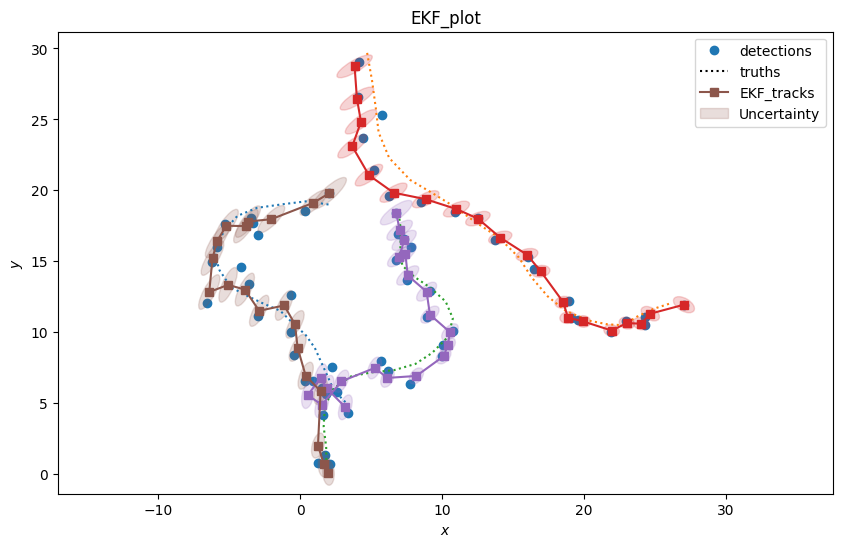

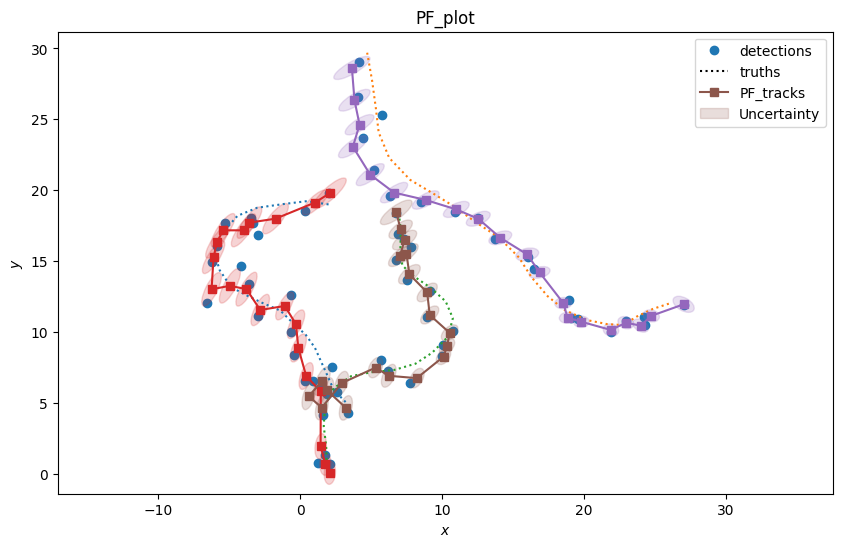

In [15]:
# Generate metrics
# ----------------
# We are now ready to generate and view all the metrics from our MultiManager.
#
# Because we have two :class:`~.TwoDPlotter` generators in our metric manager, two plots will be
# displayed when we generate the metrics. They will show the ground truth paths,
# detections, and tracks. One will display the tracks produced by the EKF tracker and the other
# will display the tracks from the PF tracker.

metrics = metric_manager.generate_metrics()

In [16]:
# We can see from the plots above that the two trackers exhibit similar performance in tracking
# the ground truths.
#
# Let's look at the metrics we've generated to compare them further. We'll start by printing out
# the basic metrics which give us information on the number of tracks vs targets.

for generator in metrics.keys():
    if 'basic' in generator:
        print(f'\n{generator}:')
        for metric_key, metric in metrics[generator].items():
            print(f"{metric.title}: {metric.value}")


basic_EKF:
Number of targets: 3
Number of tracks: 3
Track-to-target ratio: 1.0

basic_PF:
Number of targets: 3
Number of tracks: 3
Track-to-target ratio: 1.0


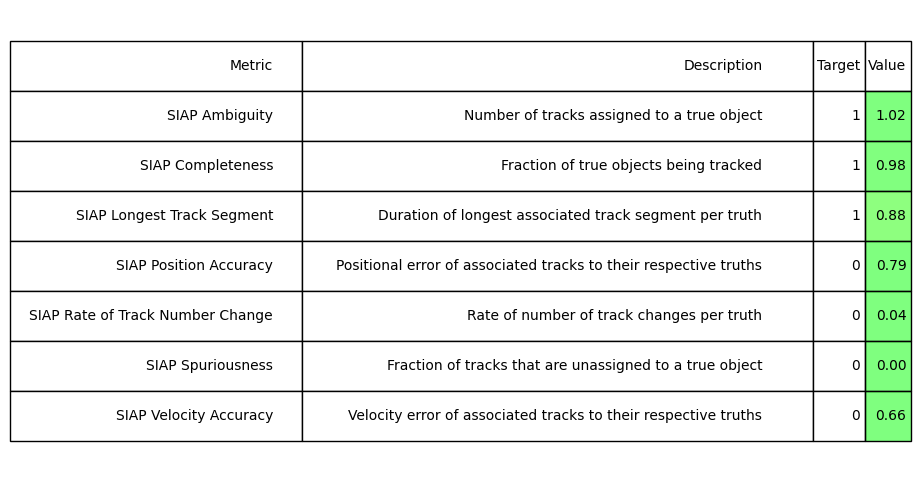

In [17]:
# The basic metrics show that both the EKF and the PF have successfully produced tracks for each
# of the ground truth paths so have a 1:1 track-to-target ratio.
#
# Next, we'll look at the averages of each of the SIAP metrics to compare.
#
# First, we extract the SIAP averages from the :class:`~.MultiManager`. Then, we use the
# :class:`~.SIAPTableGenerator` to display the average metrics in a table which shows us
# descriptions for each metric.
#
# We first create a table for the EKF SIAPs:

from stonesoup.metricgenerator.metrictables import SIAPTableGenerator

siap_metrics = metrics['SIAP_EKF-truth']
siap_averages_EKF = {siap_metrics.get(metric) for metric in siap_metrics
                     if metric.startswith("SIAP") and not metric.endswith(" at times")}
siap_table = SIAPTableGenerator(siap_averages_EKF).compute_metric()

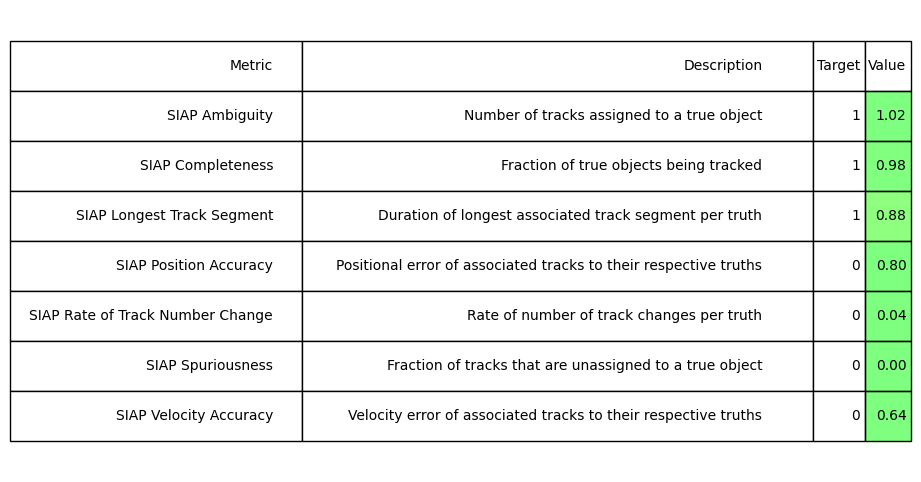

In [18]:
# Now we produce a table for the PF SIAPs for comparison:

siap_metrics = metrics['SIAP_PF-truth']
siap_averages_PF = {siap_metrics.get(metric) for metric in siap_metrics
                    if metric.startswith("SIAP") and not metric.endswith(" at times")}
siap_table = SIAPTableGenerator(siap_averages_PF).compute_metric()

In [19]:
#
# We can see that the values for most of the SIAP metric averages are similar between
# the trackers, again showing their tracking quality is very similar. Other specific
# observations include:
#
# - SIAP Ambiguity of just above 1 indicates that there are places where multiple tracks overlap
#   the same section of ground truth path, which we can see is the case from the plots above.
# - The Longest Track Segment (0.88) indicates that, on average, the three different tracks
#   produced are not following 100% of the ground truth paths. We can see on the lower left area
#   of our plots that the tracks have been confused.
# - Positional and velocity errors of ~0.80 and 0.66 indicate that there is some
#   distance between the tracks and ground truth paths. Again, we can see this from the plots.
#   The range for these errors is 0-infinity so the errors are not significant.
# - SIAP Spuriousness of 0 show us no tracks have been created that are not associated to a true
#   object. We might get higher spuriousness if we added clutter to our detections.

/var/folders/wk/r_3dm28j0wx2y0rl5hyq6bzc0000gn/T/ipykernel_5654/3684936172.py:41: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



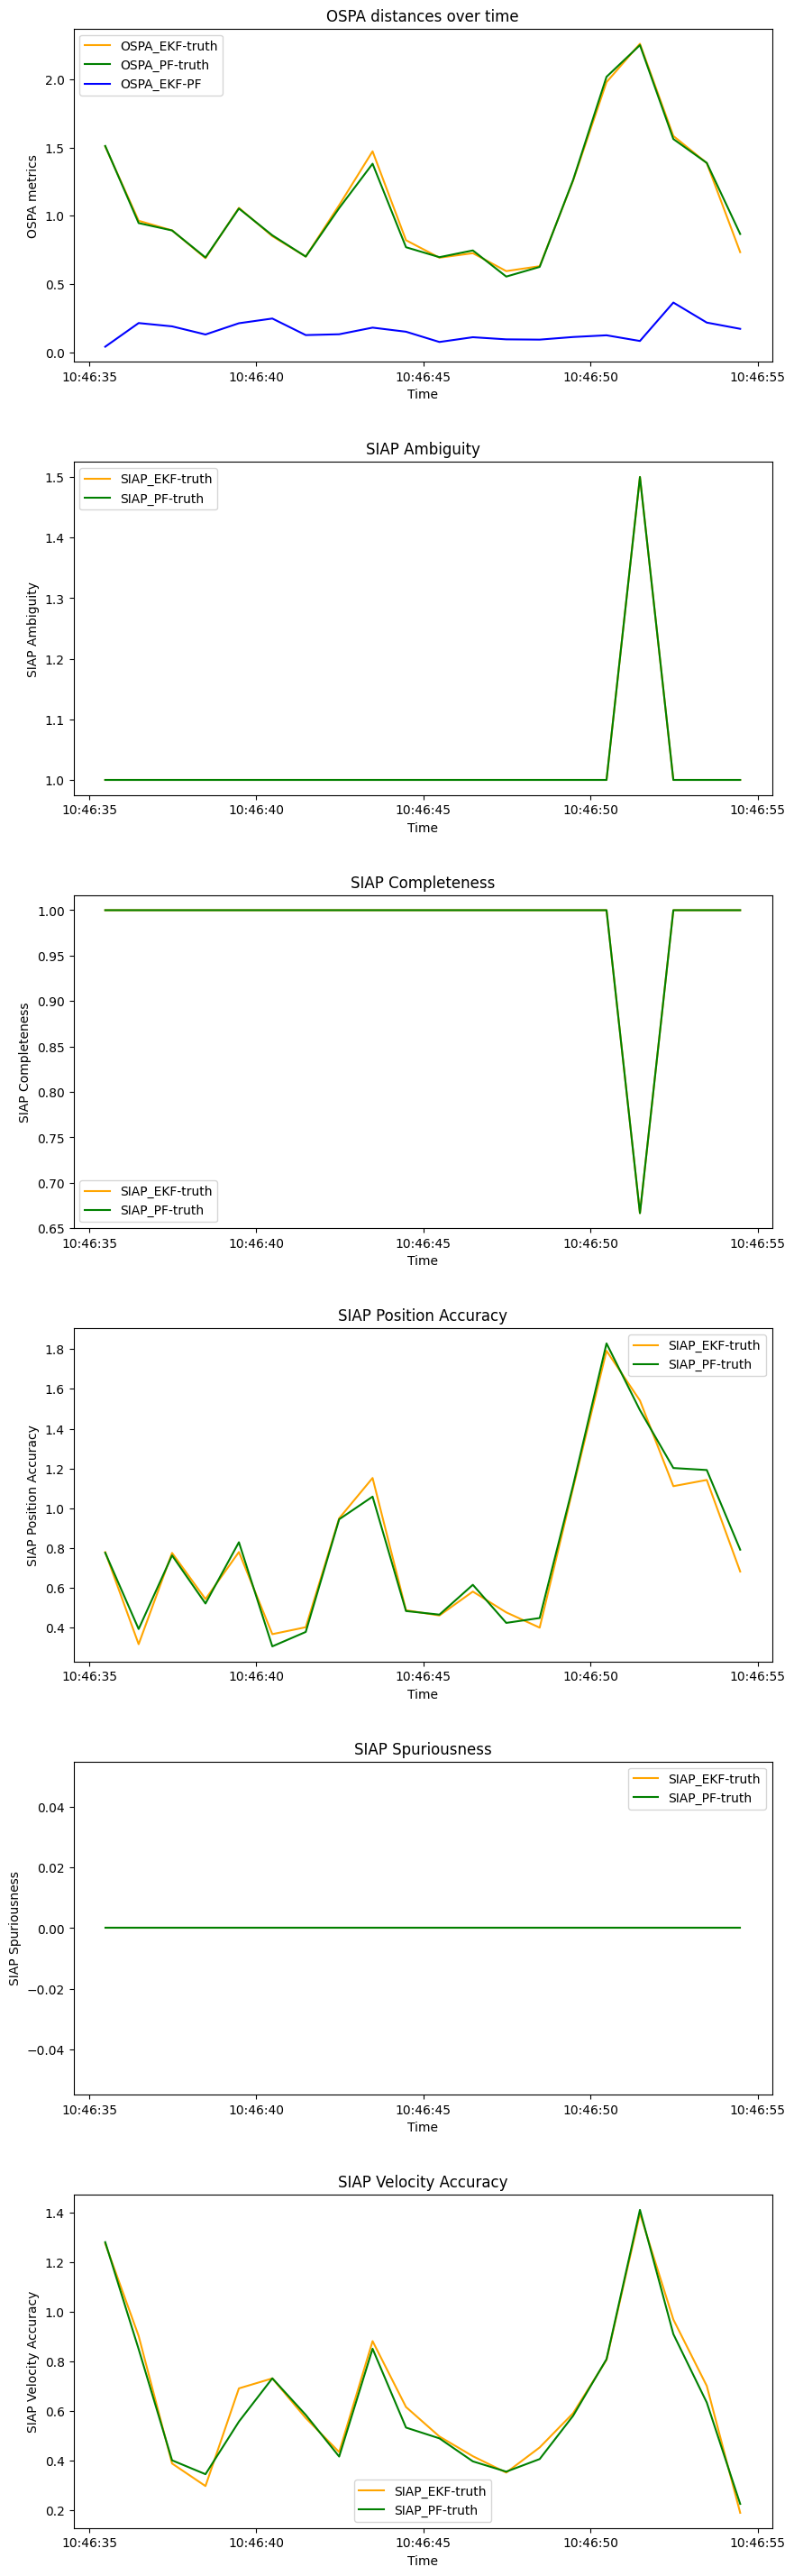

In [20]:
# Plot metrics
# ------------
# We will use :class:`~.MetricPlotter` to plot some of our metrics below.
#
# To use :class:`~.MetricPlotter`, we first create an instance of the class. We then use the
# :meth:`plot_metrics()` method to plot the metrics of our choice. Key features of
# :class:`~.MetricPlotter` include:
#
# - You can specify exactly which metrics you want to plot by specifying the optional
#   *generator_names* and *metric_names* parameters.
# - *generator_names* allows you to specify which generators you want to plot metrics from.
#   If you don't pass the *generator_names* argument, :meth:`plot_metrics()` will automatically
#   extract all plottable metrics from all metric generators in the :class:`~.MultiManager`
#   and plot them.
# - *metric_names* allows you to specify which specific metrics types to plot
#   from the metric generators. This is mostly relevant for the SIAP metrics. You can
#   view which metrics are plottable with :meth:`MetricPlotter.plottable_metrics`.
# - :meth:`plot_metrics` has a *combine_plots* argument which defaults to ``True``.
#   This means that all metrics of the same type will be plotted together on a single subplot.
# - You can specify additional formatting, like colour and linestyle, for the plots
#   produced by using keyword arguments from matplotlib pyplot.
#
# We start by plotting the OSPA distances and SIAP metrics. Plots will be combined for the
# same metric type.

from stonesoup.plotter import MetricPlotter

graph = MetricPlotter()
graph.plot_metrics(metrics, generator_names=['OSPA_EKF-truth',
                                             'OSPA_PF-truth',
                                             'OSPA_EKF-PF',
                                             'SIAP_EKF-truth',
                                             'SIAP_PF-truth'],
                   # metric_names=['OSPA distances',
                   #               'SIAP Position Accuracy at times']
                   # uncomment and run to see effect
                   color=['orange', 'green', 'blue'])

# update y-axis label and title; other subplots are displaying auto-generated title and labels
graph.axes[0].set(ylabel='OSPA metrics', title='OSPA distances over time')
graph.fig.show()

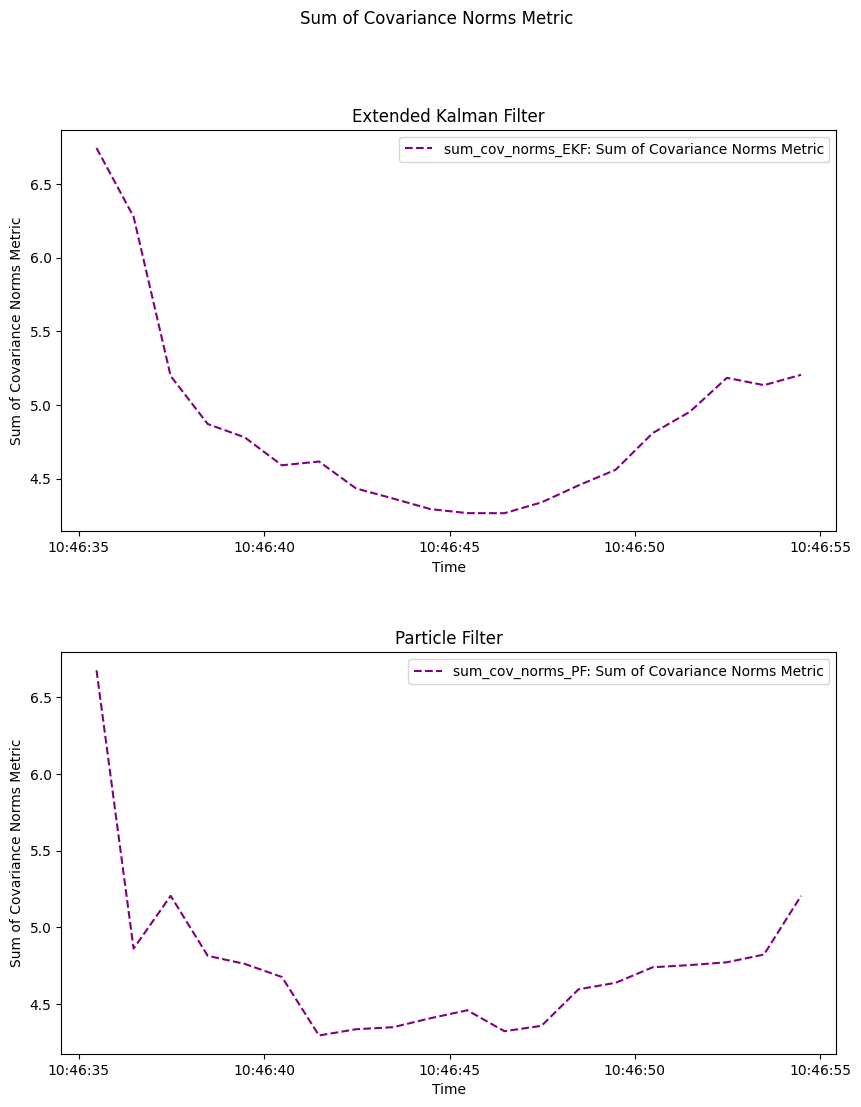

In [21]:
# From these plots, we can see that we lose some track accuracy towards the end of the
# simulation. We can once again see how similar the tracking performance is across both
# trackers. The blue line in the OSPA distances plot indicates the distance between tracks
# produced by both trackers at each time step.
#
# We now plot the sum of covariance norms metrics for both trackers. We plot the
# metrics separately and specify additional keyword arguments to customise the plot.

# sphinx_gallery_thumbnail_number = 7

graph = MetricPlotter()
graph.plot_metrics(metrics, generator_names=['sum_cov_norms_EKF',
                                             'sum_cov_norms_PF'],
                   combine_plots=False,
                   color='purple', linestyle='--')
graph.set_fig_title('Sum of Covariance Norms Metric')  # set figure title
graph.set_ax_title(['Extended Kalman Filter', 'Particle Filter'])  # set title for each axis

In [22]:
# For both trackers, we start with the highest uncertainty as tracks are initiated. Uncertainty
# decreases until just past the middle of our timeframe and begins to increase again as time
# increases.
#
# You can change the parameters in the ground truth and trackers and see how it affects the
# different metrics.

In [23]:
# .. rubric:: Footnotes
#
# .. [#] *D. Schuhmacher, B. Vo and B. Vo*, **A Consistent Metric for Performance Evaluation of
#    Multi-Object Filters**, IEEE Trans. Signal Processing 2008
# .. [#] *Karoly S., Wilson J., Dutchyshyn H., Maluda J.*, **Single Integrated Air Picture (SIAP)
#    Attributes Version 2.0**, DTIC Technical Report 2003